# Introduction to Bayesian Modeling with PyMC3
***
## 1. Mathematical Background
### 1.1 Bayes Theorem
#### Frequentist vs Bayesian
The essential difference between frequentist inference and Bayesian inference is the same as the difference between the two interpretations of what a “probability” means.

Frequentist inference is a method of statistical inference in which conclusions from data is obtained by emphasizing the frequency or proportion of the data.

Bayesian inference is a method of statistical inference in which Bayes’ theorem is used to update the probability for a hypothesis as more evidence or information becomes available.

#### Bayesian Approach to Data Analysis
Assume that you have a sample of observations (y1,y2,y3,...yn) of a random variable $Y \sim f(y|\theta)$, 
where $\theta$ is a parameter for the distribution. Here we consider $\theta$
 as a random variable as well. Following Bayes Theorem (its continuous version) we can write:
 
 $$ f(\theta|y) = \frac{f(y|\theta)f(\theta)}{f(y)}$$
 
 <li>the function $f(y|\theta)$ is called likelihood</li>
 <li>the function $f(\theta)$ is called prior</li>
 <li>the function $f(y)$ is independent of $\theta$</li>
 
 Therefore,
 
  $$ f(\theta|y) \propto likelihood * prior$$

## 2. Case Study: Medical Insurance Claim Distribution

In [2]:
from scipy.stats import expon,gamma
from numpy.random import seed
import pymc3 as pm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Sample distribution

In [3]:
df = pd.read_csv('Projects/P3/Processed_data/full_clean_data.csv',index_col=0)

In [4]:
amount = df.loc[df.amount>0].amount.dropna()


In [5]:
amount.shape

(663443,)

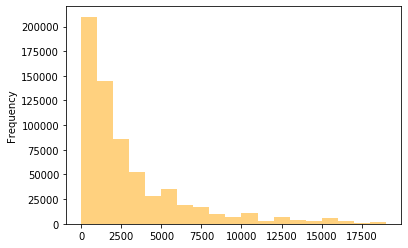

In [6]:
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')

## Exponential distribution

$f(x) = \lambda e^{-\lambda x}$ (x > 0)

In [7]:
mean = amount.mean() # mean = 1/lambda = scale
sd = amount.std()

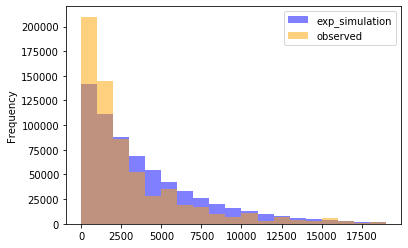

In [8]:
from numpy.random import exponential
exp = exponential(scale=mean,size=amount.shape[0])
plt.hist(exp, bins=range(0,20000,1000),label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.legend()

## Baysian Modeling with Monte Carlo Markov Chain

In [9]:
# use normal distribution as prior guess of distribution
with pm.Model() as model:
    mu_ = pm.Normal('mu', mu = mean, sigma=mean) # prior
    y_obs = pm.Exponential('y_obs', lam = 1/mu_, observed=amount) # likelihood
    trace = pm.sample(draws=1000, tune = 1000,chains=2) # draw samples from the MCMC chain

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:47<00:00, 84.61draws/s] 


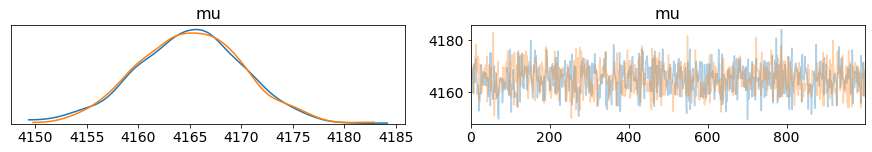

In [10]:
_ = pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c30855110>],
      dtype=object)

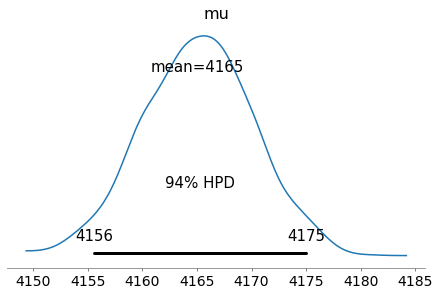

In [11]:
pm.plot_posterior(trace)

Text(0.5, 1.0, 'Frequentist Inference')

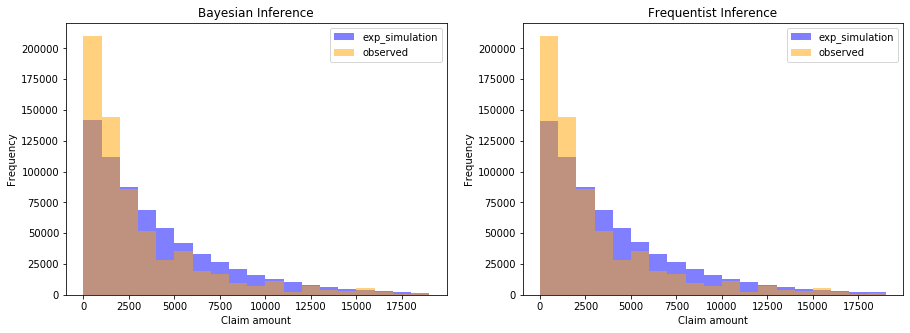

In [85]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
exp = exponential(scale=4165,size=amount.shape[0])
ax1.hist(exp, bins=range(0,20000,1000),label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange',ax=ax1)
plt.legend()
plt.xlabel('Claim amount')
plt.title('Bayesian Inference')

ax2 = fig.add_subplot(122)
exp = exponential(scale=mean,size=amount.shape[0])
ax2.hist(exp, bins=range(0,20000,1000),label='exp_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange',ax=ax2)
plt.legend()
plt.xlabel('Claim amount')
plt.title('Frequentist Inference')

## Gamma distribution simulation

$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},   x>0,   \Gamma(k) = (k-1)!$

$\mu = k\theta, \sigma^2 = k{\theta}^2$

$k= {\mu}^2/\sigma^2, \theta = \sigma^2/\mu$

In [110]:
# initial parameter of gamma distribution mean = k
k = (mean/sd)**2 # shape parameter, also called alpha
theta = sd**2/mean # scale parameter, also called 1/beta
k,theta, 1/theta

(0.04847690166421654, 85891.39612504799, 1.1642609680533252e-05)

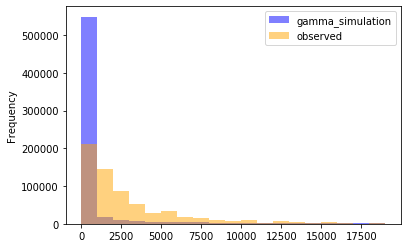

In [112]:
from numpy.random import gamma

gamma_simulation = gamma(shape=k, scale=theta,size=amount.shape[0])
plt.hist(gamma_simulation, bins=range(0,20000,1000),label='gamma_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.legend()

## Baysian Modeling with Monte Carlo Markov Chain

### Gamma distribution

In [123]:
# observation (obs)
obs = amount.loc[amount>0]
obs.mean(),amount.mean()

(4164.878438464487, 4163.748763756221)

In [124]:

# baysian optimization of parameter
with pm.Model() as model:
    
    alpha_ = pm.Exponential('alpha', k) # prior
    rate_ = pm.Exponential('rate',1/theta) # prior
    
    y_obs = pm.Gamma('y_obs', alpha=alpha_, beta=1/rate_, observed=obs) # likelihood
    trace = pm.sample(tune = 2000) # traw 2000 traces from

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [03:29<00:00, 23.84draws/s]  


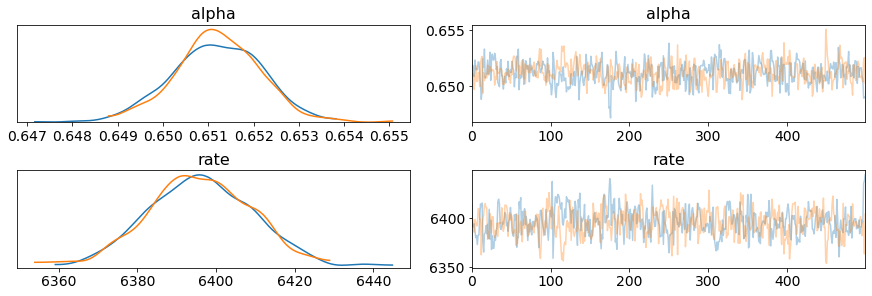

In [125]:
_ = pm.traceplot(trace)

In [1]:
pm.summary(trace)

NameError: name 'pm' is not defined

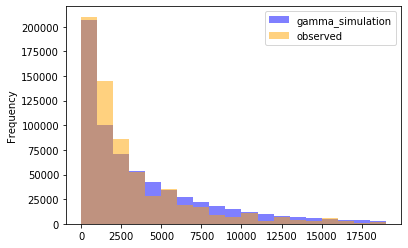

In [126]:
gamma_simulation = gamma(shape=0.651, scale=6390,size=amount.shape[0])
plt.hist(gamma_simulation, bins=range(0,20000,1000),label='gamma_simulation',alpha=0.5,color='blue')
amount.plot.hist(bins=range(0,20000,1000),label='observed',alpha=0.5,color='orange')
plt.legend()